In [1]:
from pathlib import Path

import os
import numpy as np
import torch
import nibabel as nib
import matplotlib
import matplotlib.pyplot as plt

### Let's load the scan itself


In [3]:

# make sure you have copied the example data to data/example

subject_root = Path('../data/example/S88111')
assert subject_root.exists()

path_scan = subject_root / 'T1toMNIlin.nii.gz'
assert path_scan.exists()

# load the scan to a numpy array
scan = nib.load(path_scan).get_fdata()
print(scan.shape)

(182, 218, 182)


#### Now let's visualize it

We will look at the middle slice of the coronal axis


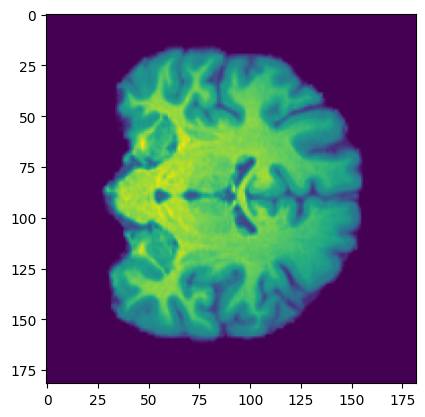

In [4]:
plt.imshow(scan[:, scan.shape[1] // 2])
plt.show()
plt.close()

### Let's load the corresponding segmentation mask


In [5]:
path_mask = (subject_root / 'synthseg_7_3_2' / 'T1toMNIlin_synthseg.nii.gz').resolve()
assert path_mask.exists(), f"File not found: {path_mask}"

# Load the mask file and get its data
mask = nib.load(path_mask).get_fdata()

# Print the shape of the mask data
print("Mask shape:", mask.shape)

Mask shape: (182, 218, 182)


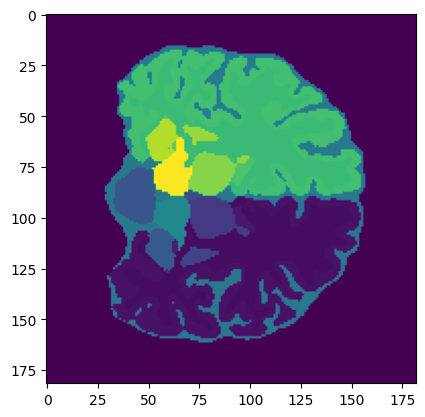

In [5]:
plt.imshow(mask[:, mask.shape[1] // 2])
plt.show()
plt.close()

It looks different - instead of continuous values, each voxel has an integer value telling us which class (Region of Interest) it belongs to.


In [6]:
np.unique(mask)

array([ 0.,  2.,  3.,  4.,  5.,  7.,  8., 10., 11., 12., 13., 14., 15.,
       16., 17., 18., 24., 26., 28., 41., 42., 43., 44., 46., 47., 49.,
       50., 51., 52., 53., 54., 58., 60.])

In [7]:
labels_str = '''
 0        background
 2        left cerebral white matter
 3        left cerebral cortex
 4        left lateral ventricle
 5        left inferior lateral ventricle
 7        left cerebellum white matter
 8        left cerebellum cortex
10        left thalamus
11        left caudate
12        left putamen
13        left pallidum
14        3rd ventricle
15        4th ventricle
16        brain-stem
17        left hippocampus
18        left amygdala
26        left accumbens area
28        left ventral DC
41        right cerebral white matter
42        right cerebral cortex
43        right lateral ventricle
44        right inferior lateral ventricle
46        right cerebellum white matter
47        right cerebellum cortex
49        right thalamus
50        right caudate
51        right putamen
52        right pallidum
53        right hippocampus
54        right amygdala
58        right accumbens area
60        right ventral DC'''

labels_dict = {}
for line in labels_str[1:].split('\n'):
    labels_dict[int(line[:2])] = line[10:]

In [8]:
# Ensure `scan` is a float type and normalize to [-1, 1]
scan = scan.astype(float)
scan = (scan - scan.min()) / (scan.max() - scan.min())  # Normalize to [0, 1]
scan = scan * 2 - 1  # Scale to [-1, 1]

# Convert to PyTorch tensor
scan_tensor = torch.tensor(scan, dtype=torch.float32)

# Print tensor shape to confirm
print("Scan tensor shape:", scan_tensor.shape)

Scan tensor shape: torch.Size([182, 218, 182])


### Transforming data into Pytorch tensors


In [9]:
import torch

# we will encode the scans as float tensors
# first, let's normalize the values to [-1, 1]
scan = (scan - scan.min()) / scan.max() * 2 - 1
scan_tensor = torch.FloatTensor(scan)
